In [111]:
import random

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from model.activation import activation_factory
from model.graph.tools import k_adjacency, normalize_adjacency_matrix

# Original

In [112]:
class UnfoldTemporalWindows(nn.Module):
    def __init__(self, window_size, window_stride, window_dilation=1):
        super().__init__()
        self.window_size = window_size
        self.window_stride = window_stride
        self.window_dilation = window_dilation

        self.padding = (window_size + (window_size-1) * (window_dilation-1) - 1) // 2
        self.unfold = nn.Unfold(kernel_size=(self.window_size, 1),
                                dilation=(self.window_dilation, 1),
                                stride=(self.window_stride, 1),
                                padding=(self.padding, 0))

    def forward(self, x):
        # Input shape: (N,C,T,V), out: (N,C,T,V*window_size)
        N, C, T, V = x.shape
        x = self.unfold(x)
        # Permute extra channels from window size to the graph dimension; -1 for number of windows
        x = x.view(N, C, self.window_size, -1, V).permute(0,1,3,2,4).contiguous()
        x = x.view(N, C, -1, self.window_size * V)
        return x


class SpatialTemporal_MS_GCN(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 A_binary,
                 num_scales,
                 window_size,
                 disentangled_agg=True,
                 use_Ares=True,
                 residual=False,
                 dropout=0,
                 activation='relu'):

        super().__init__()
        self.num_scales = num_scales
        self.window_size = window_size
        self.use_Ares = use_Ares
        A = self.build_spatial_temporal_graph(A_binary, window_size)

        if disentangled_agg:
            A_scales = [k_adjacency(A, k, with_self=True) for k in range(num_scales)]
            A_scales = np.concatenate([normalize_adjacency_matrix(g) for g in A_scales])
        else:
            # Self-loops have already been included in A
            A_scales = [normalize_adjacency_matrix(A) for k in range(num_scales)]
            A_scales = [np.linalg.matrix_power(g, k) for k, g in enumerate(A_scales)]
            A_scales = np.concatenate(A_scales)

        self.A_scales = torch.Tensor(A_scales)
        self.V = len(A_binary)

        if use_Ares:
            self.A_res = nn.init.uniform_(nn.Parameter(torch.randn(self.A_scales.shape)), -1e-6, 1e-6)
        else:
            self.A_res = torch.tensor(0)

        self.mlp = MLP(in_channels * num_scales, [out_channels], dropout=dropout, activation='linear')

        # Residual connection
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels):
            self.residual = lambda x: x
        else:
            self.residual = MLP(in_channels, [out_channels], activation='linear')

        self.act = activation_factory(activation)

    def build_spatial_temporal_graph(self, A_binary, window_size):
        assert isinstance(A_binary, np.ndarray), 'A_binary should be of type `np.ndarray`'
        V = len(A_binary)
        V_large = V * window_size
        A_binary_with_I = A_binary + np.eye(len(A_binary), dtype=A_binary.dtype)
        # Build spatial-temporal graph
        A_large = np.tile(A_binary_with_I, (window_size, window_size)).copy()
        return A_large

    def forward(self, x):
        N, C, T, V = x.shape    # T = number of windows

        # Build graphs
        A = self.A_scales.to(x.dtype).to(x.device) + self.A_res.to(x.dtype).to(x.device)

        # Perform Graph Convolution
        res = self.residual(x)
        agg = torch.einsum('vu,nctu->nctv', A, x)
        agg = agg.view(N, C, T, self.num_scales, V)
        agg = agg.permute(0,3,1,2,4).contiguous().view(N, self.num_scales*C, T, V)
        out = self.mlp(agg)
        out += res
        return self.act(out)

In [113]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu', dropout=0):
        super().__init__()
        channels = [in_channels] + out_channels
        self.layers = nn.ModuleList()
        for i in range(1, len(channels)):
            if dropout > 0.001:
                self.layers.append(nn.Dropout(p=dropout))
            self.layers.append(nn.Conv2d(channels[i-1], channels[i], kernel_size=1))
            self.layers.append(nn.BatchNorm2d(channels[i]))
            self.layers.append(activation_factory(activation))

    def forward(self, x):
        # Input shape: (N,C,T,V)
        for layer in self.layers:
            x = layer(x)
        return x

In [114]:
class MS_G3D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 A_binary,
                 num_scales,
                 window_size,
                 window_stride,
                 window_dilation,
                 embed_factor=1,
                 activation='relu'):
        super().__init__()
        self.window_size = window_size
        self.out_channels = out_channels
        self.embed_channels_in = self.embed_channels_out = out_channels // embed_factor
        if embed_factor == 1:
            self.in1x1 = nn.Identity()
            self.embed_channels_in = self.embed_channels_out = in_channels
            # The first STGC block changes channels right away; others change at collapse
            if in_channels == 3:
                self.embed_channels_out = out_channels
        else:
            self.in1x1 = MLP(in_channels, [self.embed_channels_in])

        self.gcn3d = nn.Sequential(
            UnfoldTemporalWindows(window_size, window_stride, window_dilation),
            SpatialTemporal_MS_GCN(
                in_channels=self.embed_channels_in,
                out_channels=self.embed_channels_out,
                A_binary=A_binary,
                num_scales=num_scales,
                window_size=window_size,
                use_Ares=True
            )
        )

        self.out_conv = nn.Conv3d(self.embed_channels_out, out_channels, kernel_size=(1, self.window_size, 1))
        self.out_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        N, _, T, V = x.shape
        x = self.in1x1(x)
        # Construct temporal windows and apply MS-GCN
        x = self.gcn3d(x)

        # Collapse the window dimension
        x = x.view(N, self.embed_channels_out, -1, self.window_size, V)
        x = self.out_conv(x).squeeze(dim=3)
        x = self.out_bn(x)

        # no activation
        return x

In [115]:
class MultiWindow_MS_G3D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 A_binary,
                 num_scales,
                 window_sizes=[3,5],
                 window_stride=1,
                 window_dilations=[1,1]):

        super().__init__()
        self.gcn3d = nn.ModuleList([
            MS_G3D(
                in_channels,
                out_channels,
                A_binary,
                num_scales,
                window_size,
                window_stride,
                window_dilation
            )
            for window_size, window_dilation in zip(window_sizes, window_dilations)
        ])

    def forward(self, x):
        # Input shape: (N, C, T, V)
        out_sum = 0
        for gcn3d in self.gcn3d:
            out_sum += gcn3d(x)
        # no activation
        return out_sum

In [116]:
x = torch.load('/home/gpu/Kaggle/GOOGLE-ASL/x.pt', map_location='cpu')
c1 = 78
with open('/home/gpu/Kaggle/GOOGLE-ASL/A_binary.npy', 'rb') as fid:
    A_binary = np.load(fid)

num_g3d_scales = 6

seed = 42
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

gcn3d1 = MultiWindow_MS_G3D(3, c1, A_binary, num_g3d_scales, window_stride=1)

In [117]:
or_out = gcn3d1(x)
or_out.shape

torch.Size([32, 78, 20, 137])

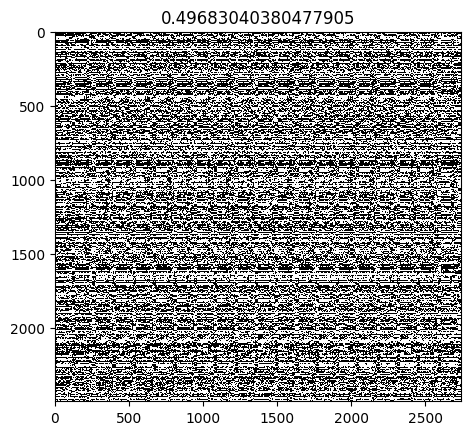

In [118]:
plt.imshow((or_out <= 0).view(-1, 20*137), cmap='gray', interpolation='nearest')
plt.title(((or_out <= 0).sum() / or_out.numel()).item())
plt.show()

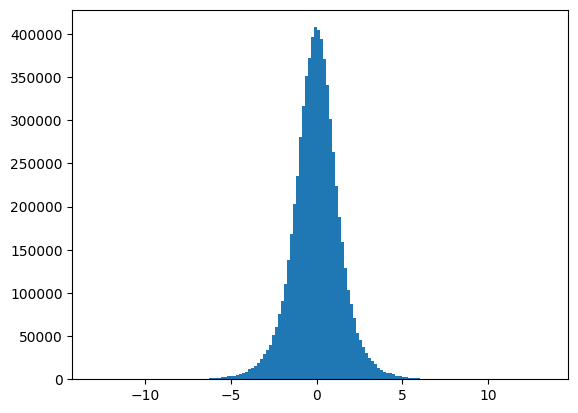

In [119]:
plt.hist(or_out.detach().view(-1), 150);

In [120]:
or_out.min().item(), or_out.max().item()

(tensor(-12.9220, grad_fn=<MinBackward1>),
 tensor(13.3576, grad_fn=<MaxBackward1>))

As we can more than half of the values produced by an untrained `MultiWindow_MS_G3D` are negative. Note that these outputs are going to be added to another function and then passed altogether to a ReLU activation function. 

This increases the changes that neurons at early optimization stages have zero gradient (dead neurons) and that is not optimal. 

Can we tweak the initialization parameters so outputs are not so wide-spread towards the negative? (See image and histogram above. We would like to see an almost black image.)

# Disection zone

## UnfoldTemporalWindows

In [204]:
class DisectUnfoldTemporalWindows(nn.Module):
    def __init__(self, window_size, window_stride, window_dilation=1):
        super().__init__()
        self.window_size = window_size
        self.window_stride = window_stride
        self.window_dilation = window_dilation

        self.padding = (window_size + (window_size-1) * (window_dilation-1) - 1) // 2
        self.unfold = nn.Unfold(kernel_size=(self.window_size, 1),
                                dilation=(self.window_dilation, 1),
                                stride=(self.window_stride, 1),
                                padding=(self.padding, 0))

    def forward(self, x):
        # Input shape: (N,C,T,V), out: (N,C,T,V*window_size)
        N, C, T, V = x.shape
        x = self.unfold(x)
        # Permute extra channels from window size to the graph dimension; -1 for number of windows
        x = x.view(N, C, self.window_size, -1, V).permute(0,1,3,2,4).contiguous()
        x = x.view(N, C, -1, self.window_size * V)
        return x

## SpatialTemporal_MS_GCN

In [205]:
class DisectSpatialTemporal_MS_GCN(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 A_binary,
                 num_scales,
                 window_size,
                 disentangled_agg=True,
                 use_Ares=True,
                 residual=False,
                 dropout=0,
                 activation='relu'):

        super().__init__()
        self.num_scales = num_scales
        self.window_size = window_size
        self.use_Ares = use_Ares
        A = self.build_spatial_temporal_graph(A_binary, window_size)

        if disentangled_agg:
            A_scales = [k_adjacency(A, k, with_self=True) for k in range(num_scales)]
            A_scales = np.concatenate([normalize_adjacency_matrix(g) for g in A_scales])
        else:
            # Self-loops have already been included in A
            A_scales = [normalize_adjacency_matrix(A) for k in range(num_scales)]
            A_scales = [np.linalg.matrix_power(g, k) for k, g in enumerate(A_scales)]
            A_scales = np.concatenate(A_scales)

        self.A_scales = torch.Tensor(A_scales)
        self.V = len(A_binary)

        if use_Ares:
            self.A_res = nn.init.uniform_(nn.Parameter(torch.randn(self.A_scales.shape)), -1e-1, 1e-1)
            # self.A_res = nn.init.uniform_(nn.Parameter(torch.randn(self.A_scales.shape)), -1e-6, 1e-6)
        else:
            self.A_res = torch.tensor(0)

        self.mlp = DisectMLP(in_channels * num_scales, [out_channels], dropout=dropout, activation='linear')

        # Residual connection
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels):
            self.residual = lambda x: x
        else:
            self.residual = DisectMLP(in_channels, [out_channels], activation='linear')

        self.act = activation_factory(activation)

    def build_spatial_temporal_graph(self, A_binary, window_size):
        assert isinstance(A_binary, np.ndarray), 'A_binary should be of type `np.ndarray`'
        V = len(A_binary)
        V_large = V * window_size
        A_binary_with_I = A_binary + np.eye(len(A_binary), dtype=A_binary.dtype)
        # Build spatial-temporal graph
        A_large = np.tile(A_binary_with_I, (window_size, window_size)).copy()
        return A_large

    def forward(self, x):
        N, C, T, V = x.shape    # T = number of windows

        # Build graphs
        A = self.A_scales.to(x.dtype).to(x.device) + self.A_res.to(x.dtype).to(x.device)

        # Perform Graph Convolution
        res = self.residual(x)
        agg = torch.einsum('vu,nctu->nctv', A, x)
        agg = agg.view(N, C, T, self.num_scales, V)
        agg = agg.permute(0,3,1,2,4).contiguous().view(N, self.num_scales*C, T, V)
        out = self.mlp(agg)
        out += res
        return self.act(out)

## MLP

In [206]:
class DisectMLP(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu', dropout=0):
        super().__init__()
        channels = [in_channels] + out_channels
        self.layers = nn.ModuleList()
        for i in range(1, len(channels)):
            if dropout > 0.001:
                self.layers.append(nn.Dropout(p=dropout))
            conv = nn.Conv2d(channels[i-1], channels[i], kernel_size=1, bias=False)
            nn.init.kaiming_uniform_(conv.weight, mode='fan_in', nonlinearity='relu')
            self.layers.append(conv)
            # self.layers.append(nn.Conv2d(channels[i-1], channels[i], kernel_size=1))
            self.layers.append(nn.BatchNorm2d(channels[i]))
            self.layers.append(activation_factory(activation))

    def forward(self, x):
        # Input shape: (N,C,T,V)
        for layer in self.layers:
            x = layer(x)
        return x

## MS_G3D

In [207]:
class DisectMS_G3D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 A_binary,
                 num_scales,
                 window_size,
                 window_stride,
                 window_dilation,
                 embed_factor=1,
                 activation='relu'):
        super().__init__()
        self.window_size = window_size
        self.out_channels = out_channels
        self.embed_channels_in = self.embed_channels_out = out_channels // embed_factor
        if embed_factor == 1:
            self.in1x1 = nn.Identity()
            self.embed_channels_in = self.embed_channels_out = in_channels
            # The first STGC block changes channels right away; others change at collapse
            if in_channels == 3:
                self.embed_channels_out = out_channels
        else:
            self.in1x1 = DisectMLP(in_channels, [self.embed_channels_in])

        self.gcn3d = nn.Sequential(
             DisectUnfoldTemporalWindows(window_size, window_stride, window_dilation),
            DisectSpatialTemporal_MS_GCN(
                in_channels=self.embed_channels_in,
                out_channels=self.embed_channels_out,
                A_binary=A_binary,
                num_scales=num_scales,
                window_size=window_size,
                use_Ares=True
            )
        )

        self.out_conv = nn.Conv3d(self.embed_channels_out, out_channels, kernel_size=(1, self.window_size, 1))
        # self.out_conv = nn.Conv3d(self.embed_channels_out, out_channels, kernel_size=(1, self.window_size, 1), bias=False)
        # nn.init.kaiming_normal_(self.out_conv.weight, mode='fan_in', nonlinearity='relu')
        
        self.out_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        N, _, T, V = x.shape
        x = self.in1x1(x)
        # Construct temporal windows and apply MS-GCN
        x = self.gcn3d(x)

        # Collapse the window dimension
        x = x.view(N, self.embed_channels_out, -1, self.window_size, V)
        x = self.out_conv(x).squeeze(dim=3)
        x = self.out_bn(x)

        # no activation
        return x

## MultiWindow_MS_G3D

In [208]:
class DisectMultiWindow_MS_G3D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 A_binary,
                 num_scales,
                 window_sizes=[3,5],
                 window_stride=1,
                 window_dilations=[1,1]):

        super().__init__()
        self.gcn3d = nn.ModuleList([
            DisectMS_G3D(
                in_channels,
                out_channels,
                A_binary,
                num_scales,
                window_size,
                window_stride,
                window_dilation
            )
            for window_size, window_dilation in zip(window_sizes, window_dilations)
        ])

    def forward(self, x):
        # Input shape: (N, C, T, V)
        out_sum = 0
        for gcn3d in self.gcn3d:
            out_sum += gcn3d(x)
            print(out_sum.min().item(), out_sum.max().item())
        # no activation
        return out_sum

In [209]:
seed = 42
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

dis_gcn3d1 = DisectMultiWindow_MS_G3D(3, c1, A_binary, num_g3d_scales, window_stride=1)

-8.41137981414795 7.802992343902588
-12.293731689453125 10.648669242858887
-12.293731689453125 10.648669242858887


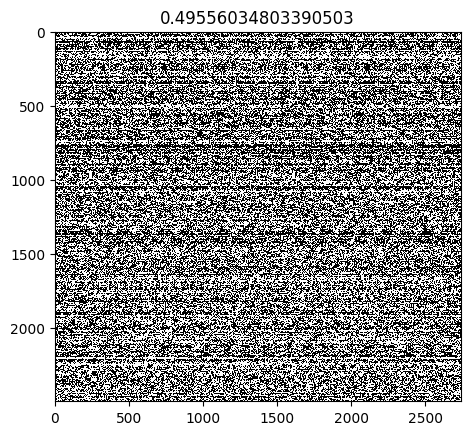

In [210]:
out = dis_gcn3d1(x)

print(out.min().item(), out.max().item())

plt.imshow((out <= 0).view(-1, 20*137), cmap='gray', interpolation='nearest')
plt.title(((out <= 0).sum() / out.numel()).item())
plt.show()

# plt.hist(out.detach().view(-1), 150);
# plt.show()